In [0]:
%%capture
!pip install wikipedia -q
import wikipedia
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
S = requests.Session()

URL = "https://en.wikipedia.org/w/api.php"

PARAMS = {
    "action": "query",
    "format": "json",
    "titles": "List_of_film_sequels_by_box-office_improvement",
    "prop": "links",
    "pllimit": 500
}

R = S.get(url=URL, params=PARAMS)
DATA = R.json()

PAGES = DATA["query"]["pages"]

sequels = []
for k, v in PAGES.items():
    for l in v["links"]:
        sequels.append(l["title"])

In [0]:
first_movie_list = []
sequel_movie_list = []
for sequel in sequels:
    page = wikipedia.page(sequel)
    summary = page.summary
    for first_movie in sequels:
        if first_movie in summary and first_movie != sequel:
            first_movie_list.append(first_movie)
            sequel_movie_list.append(sequel)

In [0]:
%%capture
! wget "https://datasets.imdbws.com/title.principals.tsv.gz"
! wget "https://datasets.imdbws.com/title.basics.tsv.gz"
! wget "https://datasets.imdbws.com/name.basics.tsv.gz"

! gunzip title.principals.tsv.gz
! gunzip title.basics.tsv.gz
! gunzip name.basics.tsv.gz

In [0]:
cast = pd.read_csv('title.principals.tsv', sep='\t', na_values = "\\N", keep_default_na = False, 
                   usecols = ['tconst','ordering','nconst','category'],
                   dtype = {'tconst': str, 'ordering': str, 'nconst': str, 'category': str})
titles = pd.read_csv('title.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                     usecols = ['tconst','primaryTitle','startYear','titleType','genres'],
                    dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64','titleType':str, 'genres': str})
names = pd.read_csv('name.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                    usecols = ['nconst','primaryName'], 
                    dtype = {'nconst': str, 'primaryName': str})

In [0]:
def remove_film_year(sequel):
  if "(" in sequel:
    i = sequel.index("(")
    return sequel[0:i-1]
  return sequel

In [0]:
first_movie_list = [remove_film_year(first_movie) for first_movie in first_movie_list]
sequel_movie_list = [remove_film_year(sequel) for sequel in sequel_movie_list]

In [8]:
sequel_pairs = pd.DataFrame({"first_movie" : first_movie_list, "sequel" : sequel_movie_list})
sequel_pairs.head()

,first_movie,sequel
0,22 Jump Street,21 Jump Street
1,For a Few Dollars More,A Fistful of Dollars
2,A Nightmare on Elm Street 2: Freddy's Revenge,A Nightmare on Elm Street
3,A Nightmare on Elm Street,A Nightmare on Elm Street 2: Freddy's Revenge
4,A Nightmare on Elm Street 3: Dream Warriors,A Nightmare on Elm Street 2: Freddy's Revenge


In [0]:
titles = titles[titles.titleType == 'movie']
cast = cast[cast.category.isin(['director','actor','actress'])]

In [0]:
def prepare_data(first_movie_list, sequel_movie_list):
  movie_titles = titles[titles.primaryTitle.isin(first_movie_list + sequel_movie_list)].copy()
  movie_titles.drop_duplicates(subset = 'primaryTitle', keep = False, inplace = True)
  movie_titles = pd.merge(movie_titles, cast, on = 'tconst')
  movie_titles = pd.merge(movie_titles, names, on = 'nconst')
  movie_titles = movie_titles.drop(columns = ['titleType','tconst','nconst'])
  
  movie_information = movie_titles.replace(['actor','actress','director'], ['act','act','dir'])
  movie_information['role'] = movie_information.category + movie_information.ordering
  movie_summary = pd.pivot_table(movie_information, columns = 'role', values = 'primaryName', index = ['primaryTitle','startYear','genres'], aggfunc = 'first') #add genres back
  movie_summary = movie_summary[['act1','act2','act3','act4','dir5']].reset_index()
  
  first_movie_titles = movie_summary[movie_summary.primaryTitle.isin(first_movie_list)]
  first_movie_titles = first_movie_titles.add_prefix('fm_')
  sequel_movie_titles = movie_summary[movie_summary.primaryTitle.isin(sequel_movie_list)]
  sequel_movie_titles = sequel_movie_titles.add_prefix('s_')
  
  sequel_pairs = pd.DataFrame({"first_movie" : first_movie_list, "sequel" : sequel_movie_list})
  
  sequel_table = pd.merge(pd.merge(first_movie_titles, sequel_pairs, left_on = 'fm_primaryTitle', right_on = 'first_movie', how = 'inner'),
                        sequel_movie_titles, left_on = 'sequel', right_on = 's_primaryTitle', how = 'inner')
  sequel_table = sequel_table[sequel_table.fm_startYear <= sequel_table.s_startYear].copy()
  sequel_table.drop(columns = ['first_movie','sequel'], inplace = True)

  return sequel_table

In [0]:
sequel_table = prepare_data(first_movie_list, sequel_movie_list)

In [12]:
sequel_table.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5
1,A Fistful of Dollars,1964,"Drama,Western",Clint Eastwood,Gian Maria Volontè,Marianne Koch,Wolfgang Lukschy,Sergio Leone,For a Few Dollars More,1965,Western,Clint Eastwood,Lee Van Cleef,Gian Maria Volontè,Mario Brega,Sergio Leone
3,A Nightmare on Elm Street 3: Dream Warriors,1987,"Fantasy,Horror",Heather Langenkamp,Robert Englund,Craig Wasson,Patricia Arquette,Chuck Russell,A Nightmare on Elm Street 4: The Dream Master,1988,Horror,Robert Englund,Rodney Eastman,John Beckman,Kisha Brackel,Renny Harlin
5,Ace Ventura: Pet Detective,1994,Comedy,Jim Carrey,Courteney Cox,Sean Young,Tone Loc,Tom Shadyac,Ace Ventura: When Nature Calls,1995,"Adventure,Comedy,Crime",Jim Carrey,Ian McNeice,Simon Callow,Maynard Eziashi,Steve Oedekerk
7,Alvin and the Chipmunks,2007,"Animation,Comedy,Family",Jason Lee,Ross Bagdasarian Jr.,Janice Karman,David Cross,Tim Hill,Alvin and the Chipmunks: The Squeakquel,2009,"Animation,Comedy,Family",Jason Lee,Zachary Levi,David Cross,Justin Long,Betty Thomas
9,Anchorman: The Legend of Ron Burgundy,2004,Comedy,Will Ferrell,Christina Applegate,Steve Carell,Paul Rudd,Adam McKay,Anchorman 2: The Legend Continues,2013,Comedy,Will Ferrell,Christina Applegate,Paul Rudd,Steve Carell,Adam McKay


In [0]:
non_sequel_movies = ['The Searchers','Chisum','She Wore a Yellow Ribbon','There Will Be Blood','Phantom Thread','Little Big Man',
                     'Bonnie and Clyde','Out of Africa','Silkwood','Florence Foster Jenkins','The Shawshank Redemption',
                     'Escape from Alcatraz','Little Big Horn','American Beauty','An American in Paris']

In [0]:
ns_first_movie_list = []
ns_sequel_movie_list = []
for first_movie in non_sequel_movies:
  for sequel_movie in non_sequel_movies:
    if first_movie != sequel_movie:
      ns_first_movie_list.append(first_movie)
      ns_sequel_movie_list.append(sequel_movie)

In [0]:
non_sequel_table = prepare_data(ns_first_movie_list, ns_sequel_movie_list)

In [16]:
non_sequel_table.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5
1,An American in Paris,1951,"Drama,Musical,Romance",Gene Kelly,Leslie Caron,Oscar Levant,Georges Guétary,Vincente Minnelli,The Searchers,1956,"Adventure,Drama,Western",John Wayne,Jeffrey Hunter,Vera Miles,Ward Bond,John Ford
6,Little Big Horn,1951,Western,Lloyd Bridges,John Ireland,Marie Windsor,Reed Hadley,Charles Marquis Warren,The Searchers,1956,"Adventure,Drama,Western",John Wayne,Jeffrey Hunter,Vera Miles,Ward Bond,John Ford
10,She Wore a Yellow Ribbon,1949,Western,John Wayne,Joanne Dru,John Agar,Ben Johnson,John Ford,The Searchers,1956,"Adventure,Drama,Western",John Wayne,Jeffrey Hunter,Vera Miles,Ward Bond,John Ford
15,An American in Paris,1951,"Drama,Musical,Romance",Gene Kelly,Leslie Caron,Oscar Levant,Georges Guétary,Vincente Minnelli,Chisum,1970,"Biography,Western",John Wayne,Forrest Tucker,Christopher George,Ben Johnson,Andrew V. McLaglen
16,Bonnie and Clyde,1967,"Action,Biography,Crime",Warren Beatty,Faye Dunaway,Michael J. Pollard,Gene Hackman,Arthur Penn,Chisum,1970,"Biography,Western",John Wayne,Forrest Tucker,Christopher George,Ben Johnson,Andrew V. McLaglen


In [0]:
actors_for_unsupervised = ['Al Pacino','Jack Nicholson','Jennifer Lawrence','Jodie Foster']
directors_for_unsupervised = ['Alfred Hitchcock','Steven Spielberg','George Lucas','David Lean']
names_for_unsupervised = actors_for_unsupervised + directors_for_unsupervised

In [0]:
cast_movies = pd.merge(names[names.primaryName.isin(names_for_unsupervised)],cast, on = 'nconst', how = 'inner')

In [109]:
cast_titles = pd.merge(cast_movies, titles, on = 'tconst', how = 'inner')
cast_titles.head()

,nconst,primaryName,tconst,ordering,category,titleType,primaryTitle,startYear,genres
0,nm0000033,Alfred Hitchcock,tt0013444,3,director,movie,Number 13,1922,Comedy
1,nm0000033,Alfred Hitchcock,tt0016127,5,director,movie,The Mountain Eagle,1926,"Romance,Thriller"
2,nm0000033,Alfred Hitchcock,tt0016230,5,director,movie,The Pleasure Garden,1925,"Drama,Romance"
3,nm0000033,Alfred Hitchcock,tt0017075,5,director,movie,The Lodger: A Story of the London Fog,1927,"Crime,Drama,Mystery"
4,nm0000033,Alfred Hitchcock,tt0017825,5,director,movie,When Boys Leave Home,1927,"Adventure,Drama,Thriller"


In [0]:
unlabeled_first_movie_list = []
unlabeled_sequel_movie_list = []

for name in names_for_unsupervised:
  name_movies = cast_titles[cast_titles.primaryName == name].primaryTitle.unique()
  for first_movie in name_movies:
    for sequel_movie in name_movies:
      if first_movie != sequel_movie:
        unlabeled_first_movie_list.append(first_movie)
        unlabeled_sequel_movie_list.append(sequel_movie)

In [0]:
unlabeled_table = prepare_data(unlabeled_first_movie_list, unlabeled_sequel_movie_list)

In [112]:
unlabeled_table.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5
45,The Panic in Needle Park,1971,Drama,Al Pacino,Kitty Winn,Alan Vint,Richard Bright,Jerry Schatzberg,Serpico,1973,"Biography,Crime,Drama",Al Pacino,John Randolph,Jack Kehoe,Biff McGuire,Sidney Lumet
63,Serpico,1973,"Biography,Crime,Drama",Al Pacino,John Randolph,Jack Kehoe,Biff McGuire,Sidney Lumet,The Godfather: Part II,1974,"Crime,Drama",Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,Francis Ford Coppola
69,The Panic in Needle Park,1971,Drama,Al Pacino,Kitty Winn,Alan Vint,Richard Bright,Jerry Schatzberg,The Godfather: Part II,1974,"Crime,Drama",Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,Francis Ford Coppola
86,Serpico,1973,"Biography,Crime,Drama",Al Pacino,John Randolph,Jack Kehoe,Biff McGuire,Sidney Lumet,Dog Day Afternoon,1975,"Biography,Crime,Drama",Al Pacino,John Cazale,Penelope Allen,Sully Boyar,Sidney Lumet
89,The Godfather: Part II,1974,"Crime,Drama",Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,Francis Ford Coppola,Dog Day Afternoon,1975,"Biography,Crime,Drama",Al Pacino,John Cazale,Penelope Allen,Sully Boyar,Sidney Lumet


In [113]:
sequel_table['sequel'] = 1
non_sequel_table['sequel'] = 0
unlabeled_table['sequel'] = -1
movie_pairs = pd.concat([sequel_table,non_sequel_table,unlabeled_table], axis = 0)
movie_pairs.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5,sequel
1,A Fistful of Dollars,1964,"Drama,Western",Clint Eastwood,Gian Maria Volontè,Marianne Koch,Wolfgang Lukschy,Sergio Leone,For a Few Dollars More,1965,Western,Clint Eastwood,Lee Van Cleef,Gian Maria Volontè,Mario Brega,Sergio Leone,1
3,A Nightmare on Elm Street 3: Dream Warriors,1987,"Fantasy,Horror",Heather Langenkamp,Robert Englund,Craig Wasson,Patricia Arquette,Chuck Russell,A Nightmare on Elm Street 4: The Dream Master,1988,Horror,Robert Englund,Rodney Eastman,John Beckman,Kisha Brackel,Renny Harlin,1
5,Ace Ventura: Pet Detective,1994,Comedy,Jim Carrey,Courteney Cox,Sean Young,Tone Loc,Tom Shadyac,Ace Ventura: When Nature Calls,1995,"Adventure,Comedy,Crime",Jim Carrey,Ian McNeice,Simon Callow,Maynard Eziashi,Steve Oedekerk,1
7,Alvin and the Chipmunks,2007,"Animation,Comedy,Family",Jason Lee,Ross Bagdasarian Jr.,Janice Karman,David Cross,Tim Hill,Alvin and the Chipmunks: The Squeakquel,2009,"Animation,Comedy,Family",Jason Lee,Zachary Levi,David Cross,Justin Long,Betty Thomas,1
9,Anchorman: The Legend of Ron Burgundy,2004,Comedy,Will Ferrell,Christina Applegate,Steve Carell,Paul Rudd,Adam McKay,Anchorman 2: The Legend Continues,2013,Comedy,Will Ferrell,Christina Applegate,Paul Rudd,Steve Carell,Adam McKay,1


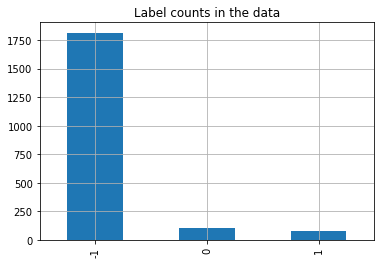

In [114]:
movie_pairs.sequel.value_counts().plot(kind='bar')
plt.title('Label counts in the data')
plt.grid()

In [0]:
def get_plot(movie_table):
  plot_list = {}
  plot_not_found = []
  movie_list = np.array(pd.concat([movie_table.fm_primaryTitle, movie_table.s_primaryTitle]))
  year_list = np.array(pd.concat([movie_table.fm_startYear, movie_table.s_startYear]))
  for movie, year in zip(movie_list, year_list):
    if movie not in plot_list and movie not in plot_not_found:
      movie_y_f, movie_f = movie + ' (' + str(year) + ' film)', movie + ' (film)'
      search1 = wikipedia.search(movie_y_f)[0]
      search2 = wikipedia.search(movie_f)[0]
      if search1 == movie_y_f:
        search = movie_y_f
      elif search2 == movie_f:
        search = movie_f
      else:
        search = movie
      try:
        page = wikipedia.page(search)
        plot = page.section("Plot")
        if not plot:
          plot = page.section("Synopsis")
        if not plot:
          plot = page.section("Plot summary")
        if not plot:
          plot = page.section("Summary")
        if plot:
          plot_list[movie] = plot
        else:
          plot_not_found.append(movie)
          print('plot not found: %s' %movie)
      except:
          print('movie not found: %s' %movie)
          plot_not_found.append(movie)
          pass

  return plot_list

In [142]:
movie_plots = get_plot(movie_pairs)

plot not found: The Local Stigmatic
plot not found: Twilight Zone: The Movie
plot not found: A Beautiful Planet
plot not found: Mob Girl
plot not found: Untitled Lila Neugebauer Project
plot not found: Back Door to Hell
plot not found: The Shooting
plot not found: Hoffa
plot not found: The Sound Barrier
plot not found: Doctor Zhivago
plot not found: Stop Calling Me Baby!
plot not found: When Boys Leave Home
plot not found: Strauss' Great Waltz
movie not found: Untitled Indiana Jones Project


In [0]:
movie_plots

In [0]:
documents = list(movie_plots.values())
doc_titles = list(movie_plots.keys())

In [144]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stopwords_set = set(stopwords.words('english'))

In [0]:
def clean_text(document):
  document_lower = document.lower() # set everything to lower case
  document_no_punctuation = document_lower.translate(str.maketrans('', '', string.punctuation)) # strip all punctuation
  words = document_no_punctuation.split()
  words_no_stopwords = [word for word in words if word not in stopwords_set]
  return words_no_stopwords[0:100]

In [0]:
documents_text = [clean_text(document) for document in documents]

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [0]:
documents_tagged = [TaggedDocument(doc, [doc_titles[i]]) for i, doc in enumerate(documents_text)]
model = Doc2Vec(documents_tagged, vector_size=100, window=2, min_count=1, workers=4)

In [150]:
max_epochs = 100
vec_size = 100
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=3,
                dm =1)
  
model.build_vocab(documents_tagged)

for epoch in range(max_epochs):
    model.train(documents_tagged,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  app.launch_new_instance()


In [151]:
model.docvecs[0]

array([ 2.3352163e+00, -9.3940276e-01, -3.5145288e+00, -2.5059369e+00,
        5.9273833e-01, -9.8043776e-01,  1.8411095e+00, -2.4896834e+00,
       -2.3312054e+00,  2.7428854e+00,  3.4060965e+00, -6.1964941e-01,
       -2.8789761e+00, -1.5234046e+00,  3.5360720e+00,  9.1690339e-02,
       -3.1750128e-01,  5.9617462e+00,  2.1032815e+00, -4.2712536e-01,
       -1.7011275e+00, -5.0547468e-03, -1.1726497e+00, -3.2741127e+00,
        9.5928419e-01,  1.2077439e+00,  1.7076331e+00, -1.4174840e+00,
        2.4793174e+00, -1.8154776e+00, -2.7249050e+00, -1.1188055e+00,
        6.5214849e-01,  4.3292956e+00, -7.4229747e-01, -1.4889295e-01,
        5.4960173e-01, -4.3738160e+00,  2.1927746e-01, -1.5054750e+00,
        2.0306897e-01,  1.4535788e+00, -1.9231137e+00, -1.5864176e+00,
        4.1748509e+00, -1.7231579e+00,  6.0551900e-01, -4.3739772e+00,
       -3.8094538e-01,  1.8535907e+00,  9.3356442e-01, -1.1851437e+00,
       -1.9842265e+00, -4.0438080e-01, -2.7154007e+00, -1.4929695e+00,
      

In [152]:
model.docvecs.most_similar([model.docvecs[2]])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Ace Ventura: Pet Detective', 1.0),
 ('Friday the 13th Part 2', 0.5687369108200073),
 ('Toy Story 2', 0.5296435952186584),
 ('The Adventures of Tintin', 0.5176386833190918),
 ('Ace Ventura: When Nature Calls', 0.5030211210250854),
 ('Iron Man 3', 0.4947996437549591),
 ('The Panic in Needle Park', 0.4698691964149475),
 ('Manglehorn', 0.45962414145469666),
 ('Rear Window', 0.4580562114715576),
 ('Rocky III', 0.45727309584617615)]

In [153]:
model.docvecs.most_similar([model.docvecs['Magnum Force']], topn = 5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Magnum Force', 1.0),
 ("O'Hara's Wife", 0.5051355361938477),
 ('Dirty Harry', 0.48744121193885803),
 ('The Departed', 0.4823799729347229),
 ('88 Minutes', 0.4753873646259308)]

In [154]:
model.most_similar('death')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bag', 0.3131186068058014),
 ('lead', 0.3051057755947113),
 ('old', 0.3008382320404053),
 ('growing', 0.2874433398246765),
 ('heart', 0.2867318391799927),
 ('takes', 0.280828058719635),
 ('gale', 0.2750994563102722),
 ('retaliation', 0.2749555706977844),
 ('history', 0.274824857711792),
 ('ten', 0.274419367313385)]

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [156]:
cosine_similarity([model.docvecs['Dirty Harry']],[model.docvecs['Magnum Force']])

array([[0.48744124]], dtype=float32)